In [75]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from dataclasses import dataclass 
import matplotlib.pyplot as plt 

In [76]:
class LinearRegression:
    
    def __init__(self, X, y, learningRate, epsilon, maxIteration, gd = False, lamda = 0, stgd = False):
        """This function is for defining variables"""
        self.X = X
        self.y = y
        self.learningRate = learningRate
        self.epsilon = epsilon
        self.maxIteration = maxIteration
        self.gd = gd
        self.lamda = lamda
        self.stgd = stgd
        
    def splitData(self):
        """This function is to split the data from datset"""
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size = 0.3, shuffle = True)
        return X_train, X_test, y_train, y_test
    
    def addX0(self, X):
        """This function add ones to cater the intercept term"""
        return np.column_stack([np.ones(X.shape[0]), X])
    
    def normalizeTrain(self, X):
        """This function is normalize the train data and add the ones after normalizing"""
        mean = np.mean(X, axis = 0)
        std = np.std(X, axis = 0)
        X_norm = (X - mean)/ std
        X_norm = self.addX0(X_norm)
        return X_norm, mean, std 
    
    def normalizeTest(self, X, mean, std):
        """This function normalize the test data using the mean and std of training data"""
        X_norm = (X - mean)/ std
        X_norm = self.addX0(X_norm)
        return X_norm
    
    def rank(self, X):
        """This function is calculating the rank of matrics by using singular value decemposition"""
        v, s, u = np.linalg.svd(X)
        rank = sum([True if i > 0 else False for i in s])
        return rank
    
    def checkFullrank(self, X):
        """This function check either the matrics if full rank or not"""
        rank = self.rank(X)
        if rank == min(X.shape):
            print("its full rank")
            self.Fullrank = True
        else:
            self.Fullrank = False
            print("Not a full rank")
    
    def checkLowRank(self, X):
        """This function is to check whether the matrics is low rank or not"""
        if X.shape[1] > X.shape[0]:
            self.LowRank = True
        else:
            self.LowRank = False
    
    def normalEquation(self, X, y):
        """This function is for solving with closed form"""
        self.w = np.linalg.inv(X.T.dot(X) + self.lamda * np.eye(X.shape[1])).dot(X.T).dot(y)
        
    def predict(self, X):
        """This function will give predicted values in return"""
        return X.dot(self.w)
    
    def sse(self, X, y):
        """This function is for calculating sum of squared errors"""
        y_hat = self.predict(X)
        return ((y_hat - y)**2).sum()

    def costFunction(self, X, y):
        """This function is give the cost function value for given X and y"""
        sse = self.sse(X, y)
        return sse/2
    
    def costDerivative(self, X, y):
        """This function is for getting the differentiated cost function value"""
        y_hat = self.predict(X)
        return (y_hat - y).dot(X) + self.lamda * self.w
    
    def gradientDescent(self, X, y):
        """This function is for solving the regression problem with the gradient descent"""
        errors = []
        prev_erro = float(np.inf)
        
        for i in tqdm(range(self.maxIteration)):
            grad = self.costDerivative(X, y)
            self.w = self.w - self.learningRate * grad
            current_error = self.costFunction(X, y)
            errors.append(current_error)
            if abs(current_error - prev_erro) < self.epsilon:
                print("The model stopped learning")
                break
            prev_erro = current_error
            
        self.plot_rmse(errors)
        
    def stochiasticGD (self, X, y):
        """This function is for solving the regression problem using stochiatic gradient descent"""
        errors = []
        prev_erro = float(np.inf)
        
        for i in tqdm(range(self.maxIteration)):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, shuffle = True)
            grad = self.costDerivative(X_train, y_train)
            self.w = self.w - self.learningRate * grad
            current_error = self.costFunction(X_train, y_train)
            errors.append(current_error)
            if abs(current_error - prev_erro) < self.epsilon:
                print("The model stopped learning")
                break
            prev_erro = current_error
            
        self.plot_rmse(errors)
            
    
    def fit(self):
        """This function is used for combiling all the functions together to predict the optimal weights, sse, rmse,
        error cost"""
        X_train, X_test, y_train, y_test = self.splitData()
        X_train, mean, std = self.normalizeTrain(X_train)
        X_test = self.normalizeTest(X_test, mean, std)
        
        self.checkFullrank(X_train)
        self.checkLowRank(X_train)
        
        if self.Fullrank and not self.LowRank and X_train.shape[0] < 10000 and not self.gd and not self.stgd:
            self.normalEquation(X_train, y_train)
        else:
            if self.stgd and not self.gd:
                self.w = np.zeros(X_train.shape[1])
                self.stochiasticGD(X_train, y_train)
            else:
                self.w = np.zeros(X_train.shape[1])
                self.gradientDescent(X_train, y_train)
    
        print(self.w)
        print("SSE value:", self.sse(X_test, y_test))
        print("RMSE value:", math.sqrt(self.sse(X_test, y_test)/y_test.shape[0]))
        
    def plot_rmse(self, error_sequence):
        """
        @X: error_sequence, vector of rmse
        @does: Plots the error function
        @return: plot
        """
        # Data for plotting
        s = np.array(error_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

       # ax.set(xlabel='iterations', ylabel = self.errors,
              # title='{} trend'.format(self.errors))
        #ax.grid()

        plt.legend(bbox_to_anchor=(1.05,1), loc=2, shadow=True)
        plt.show()     

# Housing Dataset

In [77]:
df1 = pd.read_csv("housing.csv")
df1.head(2)

,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7


In [80]:
# Close form solution
clf = LinearRegression(X = df1.values[:, 0:-1], y = df1.values[:, -1], learningRate = 0.0001, 
                       gd = False, maxIteration = 10000, epsilon = 0.00025)

In [81]:
clf.fit()

its full rank
[22.17507082 -1.03797751  0.87242671 -0.05645523  0.82426689 -1.8724425
  2.61215373 -0.34291558 -2.98224954  2.6334807  -2.24177995 -1.76006165
  0.58491549 -3.34900731]
SSE value: 3027.2292955606536
RMSE value: 4.462732594233703


In [82]:
# Solving with gradient descent without regularix=zation
clf = LinearRegression(X = df1.values[:, 0:-1], y = df1.values[:, -1], learningRate = 0.00005, 
                       gd = True, maxIteration = 100000, epsilon = 0.00025, lamda = 0)

its full rank


  3%|▉                                | 2996/100000 [00:00<00:04, 20505.63it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The model stopped learning


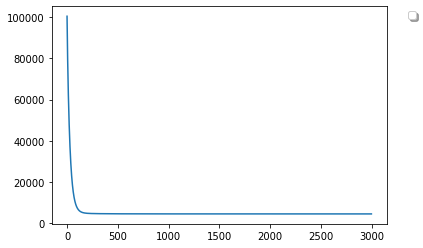

[22.43314448 -0.49482074  1.13025294 -0.18096473  0.76723967 -2.10801541
  2.64083666 -0.26845876 -3.68565328  2.40532644 -1.82891045 -1.8613039
  0.89649235 -4.03898399]
SSE value: 2062.0649162330055
RMSE value: 3.6832345233726986


In [83]:
clf.fit()

In [84]:
#Gradient Descent with regularization
clf = LinearRegression(X = df1.values[:, 0:-1], y = df1.values[:, -1], learningRate = 0.00005, 
                       gd = True, maxIteration = 5000, epsilon = 0.0005, lamda = 2)

its full rank


 80%|███████████████████████████▉       | 3983/5000 [00:00<00:00, 20384.85it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The model stopped learning


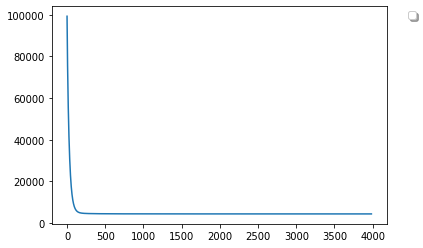

[22.20788732 -1.2467653   1.09221121 -0.03005215  0.70220767 -2.21390993
  2.51944276 -0.0964965  -3.32048731  2.75656637 -1.91850284 -2.17606921
  0.93320758 -3.79015573]
SSE value: 2449.1126891966173
RMSE value: 4.014048265972482


In [85]:
clf.fit()

In [86]:
# Using Stochaistic Gradient Descent
clf = LinearRegression(X = df1.values[:, 0:-1], y = df1.values[:, -1], learningRate = 0.00005, 
                       gd = False, maxIteration = 10000, epsilon = 0.001, lamda = 0, stgd = True)

its full rank


100%|██████████████████████████████████| 10000/10000 [00:02<00:00, 3424.91it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


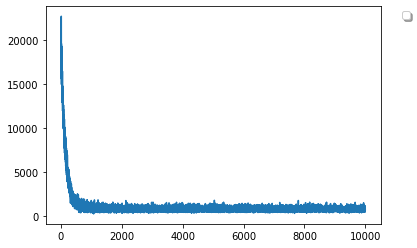

[22.47442525 -0.96917789  0.95012696 -0.26929434  0.8567567  -1.90574762
  2.55244552  0.13080143 -3.20263251  2.30452922 -1.52611492 -1.91157193
  0.91026025 -3.91407933]
SSE value: 3419.3235411215533
RMSE value: 4.7429473550358745


In [87]:
clf.fit()

# On Yachdata Dataset

In [88]:
df2 = pd.read_csv("yachtData.csv")
df2.head(2)

,C1,C2,C3,C4,C5,C6,Y
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27


In [89]:
# With close form solution
clf = LinearRegression(X = df2.values[:, 0:-1], y = df2.values[:, -1], learningRate = 0.000005, 
                       gd = False, maxIteration = 100000, epsilon = 0.0005, lamda = 2, stgd = False)

In [90]:
clf.fit()

its full rank
[10.58626728  0.66989049 -0.86982597 -0.39584771  0.93221631  0.85138292
 12.71202394]
SSE value: 6892.859944161999
RMSE value: 8.60910991875117


In [91]:
# With gradient descent 
clf = LinearRegression(X = df2.values[:, 0:-1], y = df2.values[:, -1], learningRate = 0.000005, 
                       gd = True, maxIteration = 100000, epsilon = 0.0005, lamda = 2, stgd = False)

its full rank


  7%|██▏                              | 6748/100000 [00:00<00:03, 23599.58it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The model stopped learning


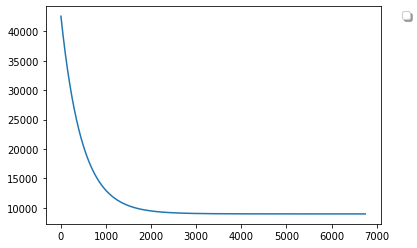

[11.46245527 -0.16235024 -0.72898622 -0.05687292 -0.40485342  0.29400338
 13.25995534]
SSE value: 6754.004148035541
RMSE value: 8.521954031588717


In [92]:
clf.fit()

In [93]:
# Using Stochaistic Gradient Descent 
clf = LinearRegression(X = df2.values[:, 0:-1], y = df2.values[:, -1], learningRate = 0.000005, 
                       gd = False, maxIteration = 100000, epsilon = 0.0005, lamda = 2, stgd = True)

its full rank


100%|████████████████████████████████| 100000/100000 [00:26<00:00, 3769.44it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


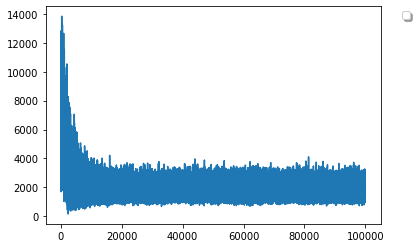

[10.25440769 -0.0650899  -0.20276321  0.69422027 -0.47749485 -0.54237126
 12.13975077]
SSE value: 5465.650490831002
RMSE value: 7.66618780002679


In [94]:
clf.fit()

# Concrete Dataset 

In [95]:
df3 = pd.read_csv("concreteData.csv")
df3.head(2)

,C1,C2,C3,C4,C5,C6,C7,C8,Y
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89


In [96]:
# Close form solution 
clf = LinearRegression(X = df3.values[:, 0:-1], y = df3.values[:, -1], learningRate = 0.0005, 
                       gd = False, maxIteration = 100000, epsilon = 0.0005, lamda = 0, stgd = False)

In [97]:
clf.fit()

its full rank
[36.0643828  13.16238583  9.43921213  6.15341586 -3.00069482  1.68619412
  1.75369145  2.00141596  7.12180878]
SSE value: 31638.379118957208
RMSE value: 10.118773465037881


In [98]:
# Using Gradient Descent
clf = LinearRegression(X = df3.values[:, 0:-1], y = df3.values[:, -1], learningRate = 0.000005, 
                       gd = True, maxIteration = 100000, epsilon = 0.00001, lamda = 0, stgd = False)

its full rank


 47%|███████████████                 | 46881/100000 [00:02<00:03, 16263.86it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The model stopped learning


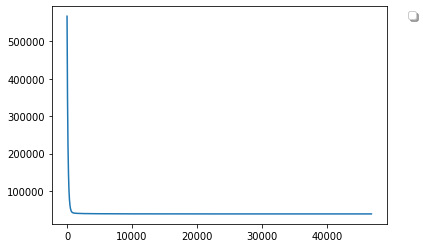

[36.00477115 12.52761425  8.90586905  5.24129037 -3.52487064  1.73228949
  1.09358394  1.3564654   6.9166455 ]
SSE value: 32782.3185085063
RMSE value: 10.300079886029838


In [99]:
clf.fit()

In [100]:
# Using Stochiastic Gradient Descent 
clf = LinearRegression(X = df3.values[:, 0:-1], y = df3.values[:, -1], learningRate = 0.000005, 
                       gd = False, maxIteration = 100000, epsilon = 0.00001, lamda = 2, stgd = True)

its full rank


100%|████████████████████████████████| 100000/100000 [00:33<00:00, 2973.84it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


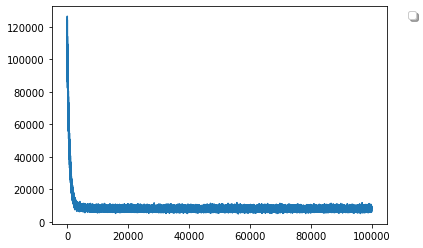

[35.70212921 10.27789586  6.9148693   4.13061651 -5.36582073  1.28354756
 -0.20219896 -0.40632008  6.8736313 ]
SSE value: 31308.962962556034
RMSE value: 10.065957715646885


In [101]:
clf.fit()

# Observations and Conclusion

1) We can apply close form solution if the matrix is full rank and on dataset with number of records are more than number of attributes. \
2) We can use gradient descent in any condition as norm 2 is always positive semidefinite and jave local minima. \
3) While using gradient descent, learning rate should be optimum. If learning rate is higher, it is highly likely we will not able to reach minima as steps in every iteration will be higher. On the other hand, if learning rate is lower, it will reach the minima but model will take very high number of itearations. \
4) The major disadvantage of linear regression is if one parameter weight have very high value as compared to others, that parameter will dominate over the other parameters. So, we use the regularization term to penalize the weights which have high values. If we choose high value of regulazation parameter, model will undrfits as it will try to minimize the weights as much as possible. On the other hand, If regularization paramter is small, model will overfit as it will not able to penalize the weights effectively. 